<a href="https://colab.research.google.com/github/mashruravi/eip-notes/blob/master/EIP_Phase_2_Assignment_5_Ravi_Suresh_Mashru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 5
## Investigating Images Misclassified by a Convolutional Neural Network

The objective of this assignment is to investigate images that are misclassified by a deep network on the CIFAR-10 dataset. The model under investigation is a pre-trained ResNet 18 model available from the [classification_models](https://github.com/qubvel/classification_models) repository. Since the model is pre-trained on ImageNet, we will first re-train it for a few epochs on CIFAR-10.

In [1]:
# Install the image-classifiers package
!pip install image-classifiers

     |████████████████████████████████| 81kB 6.8MB/s 


In [0]:
# Import libraries
import cv2
import numpy as np
from classification_models.resnet import ResNet18, preprocess_input
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

In [3]:
# Load pre-trained resnet 18
model = ResNet18((224, 224, 3), weights='imagenet', classes=10, include_top=False)

W0701 13:13:10.257476 139750539360128 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0701 13:13:10.322546 139750539360128 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0701 13:13:10.324149 139750539360128 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0701 13:13:10.327067 139750539360128 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0701 13:13:10.329799 139750

44924928/44920640 [==============================] - 2s 0us/step


Using an input size of `32x32` for ResNet 18 gives a feature map dimension of `1x1` after the last convolution layer. We cannot generate a heatmap using Grad-CAM with this. Therefore, we resize the images in CIFAR-10 to `224x224` instead and use ResNet 18 with an input size of `224x224`.

In [5]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, 10)
y_test_onehot = keras.utils.to_categorical(y_test, 10)

170500096/170498071 [==============================] - 6s 0us/step


In [6]:
# Add a new top to the model with 10 classes for CIFAR-10
x = keras.layers.GlobalAveragePooling2D()(model.output)
output = keras.layers.Dense(10, activation='softmax')(x)
new_model = keras.models.Model(inputs=[model.input], outputs=[output])
new_model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

W0701 13:14:04.496005 139750539360128 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



This what the model looks like:

In [7]:
new_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 224, 224, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn0 (Batch

__NOTE:__ The last convolutional layer is the sixth from the bottom (called `stage4_unit2_conv2`). We will be calculating the gradients of the output layer with respect to this layer.

In [8]:
# An image generator that resizes the 32x32 images in CIFAR-10 to
# 224x224 images that the network needs
def image_generator(x_train, y_train, batch_size=64):
  
  curr_index = 0
  
  while True:
    
    X = x_train[curr_index: curr_index + batch_size]
    Y = y_train[curr_index: curr_index + batch_size]
    
    curr_index += batch_size
    if curr_index > len(x_train):
      curr_index = 0
    
    batch_x = []
    batch_y = []
    
    for (x, y) in zip(X, Y):
      batch_y.append(y)
      
      x_large = cv2.resize(x, (224, 224), interpolation=cv2.INTER_AREA)
      batch_x.append(x_large)
      
    yield (
        np.array(batch_x),
        np.array(batch_y)
    )

# Retrain model for 5 epochs
new_model.fit_generator(
    image_generator(x_train, y_train),
    steps_per_epoch=50000 / 64, epochs=5
)

W0701 13:14:38.511557 139750539360128 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
782/781 [==============================] - 393s 502ms/step - loss: 0.6155 - acc: 0.7905
Epoch 2/5
782/781 [==============================] - 385s 492ms/step - loss: 0.2368 - acc: 0.9217
Epoch 3/5
782/781 [==============================] - 386s 493ms/step - loss: 0.1292 - acc: 0.9635
Epoch 4/5
782/781 [==============================] - 390s 499ms/step - loss: 0.0676 - acc: 0.9867
Epoch 5/5
782/781 [==============================] - 389s 497ms/step - loss: 0.0346 - acc: 0.9966


In [9]:
# Evaluate model performance
x_test_large = [cv2.resize(x, (224, 224), interpolation=cv2.INTER_AREA) for x in x_test]
new_model.evaluate(np.array(x_test_large), y_test_onehot, verbose=1)

10000/10000 [==============================] - 31s 3ms/step


[0.28343586914539337, 0.9166]

The model has an accuracy of __91.66%__ on the test set. We now want to analyze which images are being misclassified. We select 50 images from the test set that have been misclassified by the network and display class activation heatmaps on them.

In [10]:
# Get the predictions of the network on x_test
y_pred = new_model.predict(np.array(x_test_large))

# Get the class number of the class with highest score
y_pred_argmax = np.argmax(y_pred, axis=1)

# Indices of images that have been misclassified
misclassified = np.where(y_test.reshape(-1) - y_pred_argmax != 0)[0]

print(misclassified[:10])

[ 25  37  47  57  58  59  61  86 117 118]


In [0]:
def get_heatmap(img, class_idx):
  img = img.reshape(1, 224, 224, 3)
  preds = new_model.predict(img)
  class_output = new_model.output[:, class_idx]
  
  # Get the last convolutional layer (we saw that was the 6th layer from the last)
  last_conv_layer = new_model.layers[-6]
  
  # Calculate gradient of output wrt last conv layer
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  
  # Pool gradients leaving out channel dimension
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  
  # Pool the gradient values
  iterate = K.function([new_model.input], [pooled_grads, last_conv_layer.output[0]])
  
  pooled_grads_value, conv_layer_output_value = iterate([img])
  
  for i in range(64):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
  # Generate heatmap
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  
  # Resize the heatmap to size of image
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[2]))
  
  intheatmap = np.uint8(255 * heatmap)
  
  intheatmap = cv2.applyColorMap(intheatmap, cv2.COLORMAP_JET)
  
  # return heatmap
  return intheatmap

In [0]:
class_map = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

Correct class:  bird
Predicted class:  dog


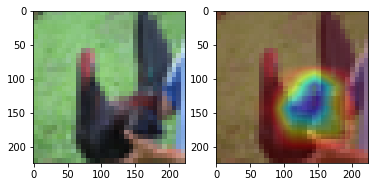


Correct class:  automobile
Predicted class:  truck


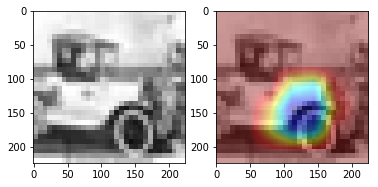


Correct class:  truck
Predicted class:  ship


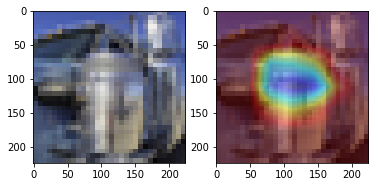


Correct class:  horse
Predicted class:  cat


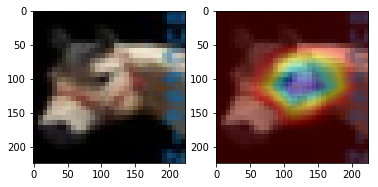


Correct class:  deer
Predicted class:  dog


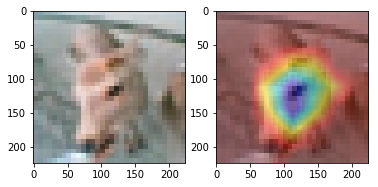


Correct class:  frog
Predicted class:  cat


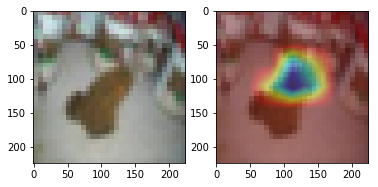


Correct class:  cat
Predicted class:  dog


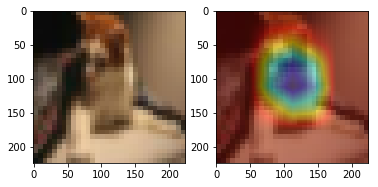


Correct class:  bird
Predicted class:  cat


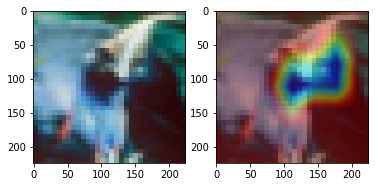


Correct class:  deer
Predicted class:  horse


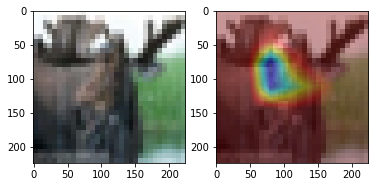


Correct class:  bird
Predicted class:  frog


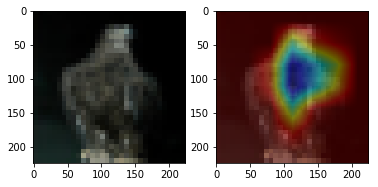


Correct class:  airplane
Predicted class:  bird


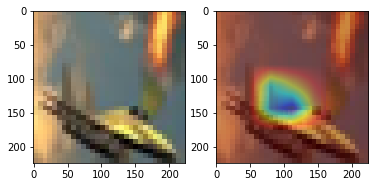


Correct class:  frog
Predicted class:  cat


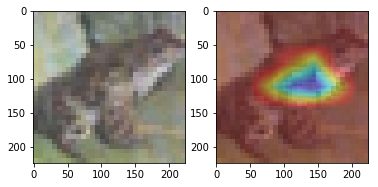


Correct class:  bird
Predicted class:  dog


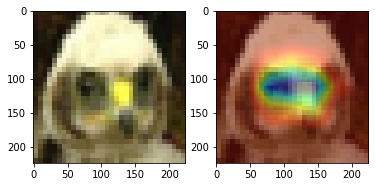


Correct class:  dog
Predicted class:  cat


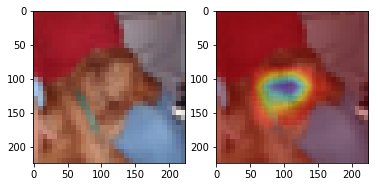


Correct class:  ship
Predicted class:  airplane


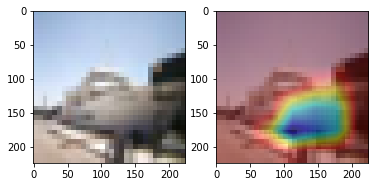


Correct class:  dog
Predicted class:  cat


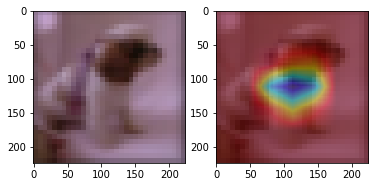


Correct class:  bird
Predicted class:  frog


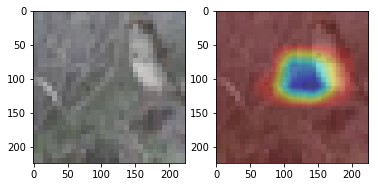


Correct class:  deer
Predicted class:  cat


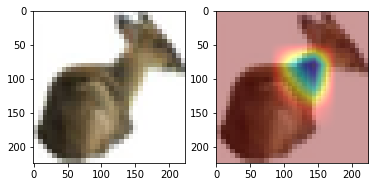


Correct class:  frog
Predicted class:  cat


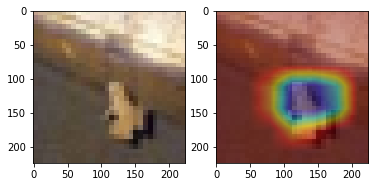


Correct class:  dog
Predicted class:  cat


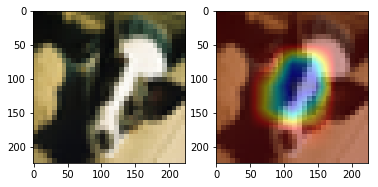


Correct class:  airplane
Predicted class:  cat


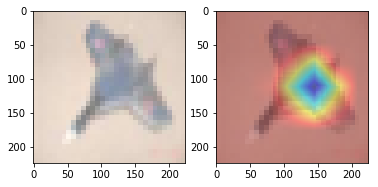


Correct class:  cat
Predicted class:  dog


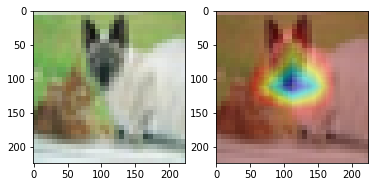


Correct class:  dog
Predicted class:  cat


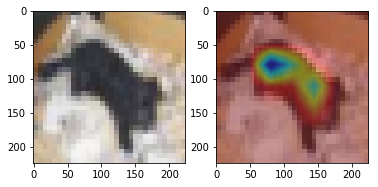


Correct class:  airplane
Predicted class:  ship


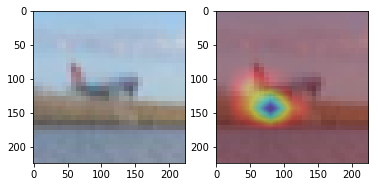


Correct class:  truck
Predicted class:  automobile


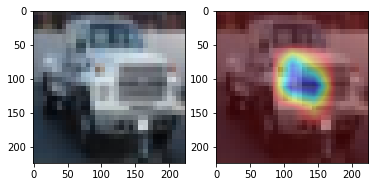


Correct class:  airplane
Predicted class:  ship


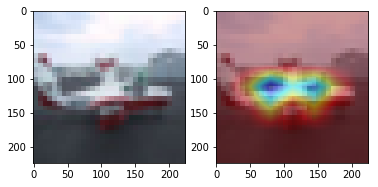


Correct class:  bird
Predicted class:  cat


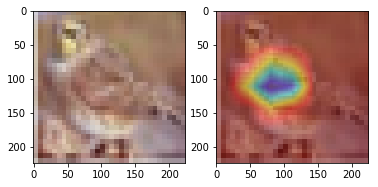


Correct class:  horse
Predicted class:  deer


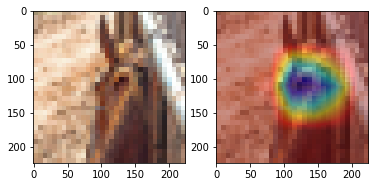


Correct class:  cat
Predicted class:  dog


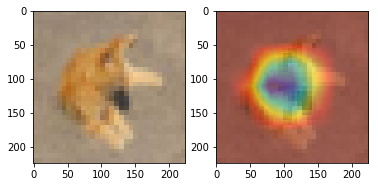


Correct class:  ship
Predicted class:  frog


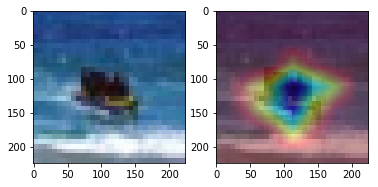


Correct class:  airplane
Predicted class:  horse


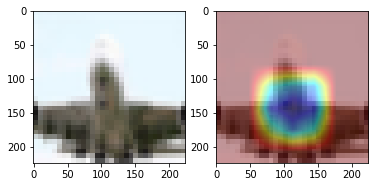


Correct class:  airplane
Predicted class:  ship


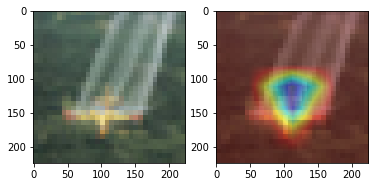


Correct class:  bird
Predicted class:  dog


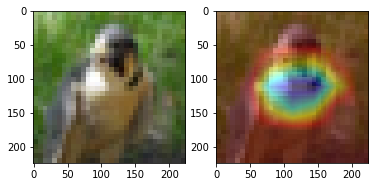


Correct class:  ship
Predicted class:  airplane


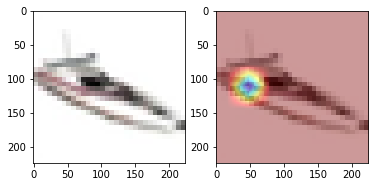


Correct class:  cat
Predicted class:  dog


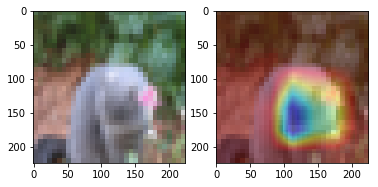


Correct class:  deer
Predicted class:  bird


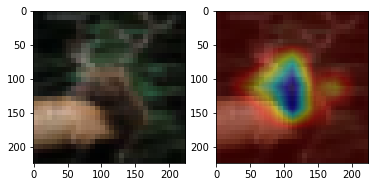


Correct class:  bird
Predicted class:  cat


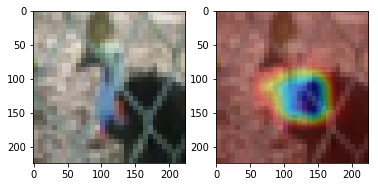


Correct class:  deer
Predicted class:  horse


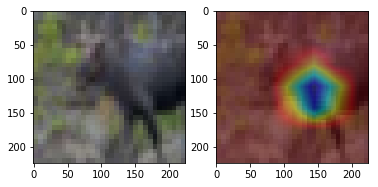


Correct class:  airplane
Predicted class:  bird


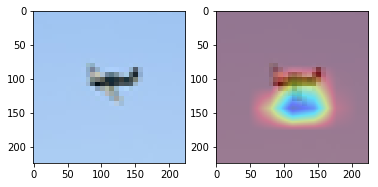


Correct class:  bird
Predicted class:  airplane


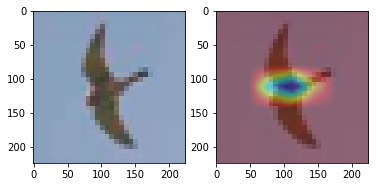


Correct class:  cat
Predicted class:  deer


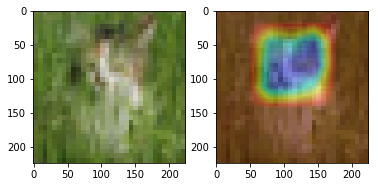


Correct class:  deer
Predicted class:  cat


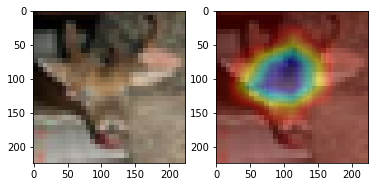


Correct class:  cat
Predicted class:  dog


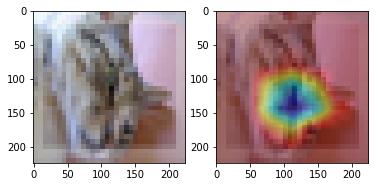


Correct class:  cat
Predicted class:  dog


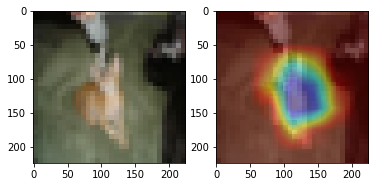


Correct class:  dog
Predicted class:  cat


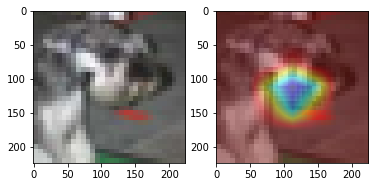


Correct class:  dog
Predicted class:  deer


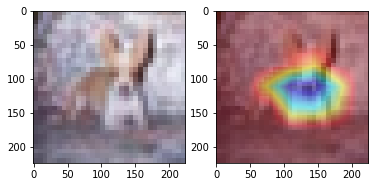


Correct class:  dog
Predicted class:  cat


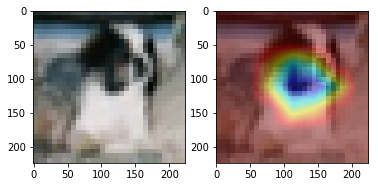


Correct class:  airplane
Predicted class:  cat


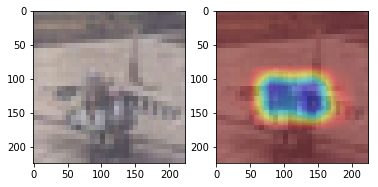


Correct class:  airplane
Predicted class:  deer


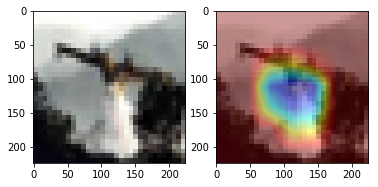


Correct class:  dog
Predicted class:  cat


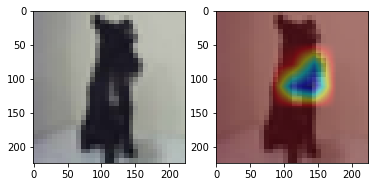

In [28]:
for idx in misclassified[:50]:
  
  x_miss = x_test_large[idx]
  y_miss = y_pred_argmax[idx]

  # Get hetmap for image
  hmap = get_heatmap(x_miss, y_miss)
  
  # Superimpose heatmap on original image
  superimposed_img = cv2.addWeighted(x_miss, 0.6, hmap, 0.4, 0)
  
  # Display correct class, predicted class, original image, and image with activation heatmap
  print('Correct class: ', class_map[y_test[idx][0]])
  print('Predicted class: ', class_map[y_miss])
  fig, ax = plt.subplots(1, 2)
  ax[0].imshow(x_miss)
  ax[1].imshow(superimposed_img)
  plt.show()
  print()